In [1]:

import argparse
import importlib
import os
import sys

import numpy as np
import torch as th
import yaml
from huggingface_sb3 import EnvironmentName
from stable_baselines3.common.callbacks import tqdm
from stable_baselines3.common.utils import set_random_seed

import rl_zoo3.import_envs  # noqa: F401 pylint: disable=unused-import
from rl_zoo3 import ALGOS, create_test_env, get_saved_hyperparams
from rl_zoo3.exp_manager import ExperimentManager
from rl_zoo3.load_from_hub import download_from_hub
from rl_zoo3.utils import StoreDict, get_model_path
import cv2
from collections import OrderedDict
import numpy as np
import torch as th
import matplotlib.pyplot as plt


def enjoy(args) -> None:  # noqa: C901
    # Going through custom gym packages to let them register in the global registory
    for env_module in args.gym_packages:
        importlib.import_module(env_module)

    env_name: EnvironmentName = args.env
    algo = args.algo
    folder = args.folder

    try:
        _, model_path, log_path = get_model_path(
            args.exp_id,
            folder,
            algo,
            env_name,
            args.load_best,
            args.load_checkpoint,
            args.load_last_checkpoint,
        )
    except (AssertionError, ValueError) as e:
        # Special case for rl-trained agents
        # auto-download from the hub
        if "rl-trained-agents" not in folder:
            raise e
        else:
            print("Pretrained model not found, trying to download it from sb3 Huggingface hub: https://huggingface.co/sb3")
            # Auto-download
            download_from_hub(
                algo=algo,
                env_name=env_name,
                exp_id=args.exp_id,
                folder=folder,
                organization="sb3",
                repo_name=None,
                force=False,
            )
            # Try again
            _, model_path, log_path = get_model_path(
                args.exp_id,
                folder,
                algo,
                env_name,
                args.load_best,
                args.load_checkpoint,
                args.load_last_checkpoint,
            )

    print(f"Loading {model_path}")

    # Off-policy algorithm only support one env for now
    off_policy_algos = ["qrdqn", "dqn", "ddpg", "sac", "her", "td3", "tqc"]

    if algo in off_policy_algos:
        args.n_envs = 1

    set_random_seed(args.seed)

    if args.num_threads > 0:
        if args.verbose > 1:
            print(f"Setting torch.num_threads to {args.num_threads}")
        th.set_num_threads(args.num_threads)

    is_atari = ExperimentManager.is_atari(env_name.gym_id)
    is_minigrid = ExperimentManager.is_minigrid(env_name.gym_id)

    stats_path = os.path.join(log_path, env_name)
    hyperparams, maybe_stats_path = get_saved_hyperparams(stats_path, norm_reward=args.norm_reward, test_mode=True)

    # load env_kwargs if existing
    env_kwargs = {}
    args_path = os.path.join(log_path, env_name, "args.yml")
    if os.path.isfile(args_path):
        with open(args_path) as f:
            loaded_args = yaml.load(f, Loader=yaml.UnsafeLoader)  # pytype: disable=module-attr
            if loaded_args["env_kwargs"] is not None:
                env_kwargs = loaded_args["env_kwargs"]
    # overwrite with command line arguments
    if args.env_kwargs is not None:
        env_kwargs.update(args.env_kwargs)

    log_dir = args.reward_log if args.reward_log != "" else None

    env = create_test_env(
        env_name.gym_id,
        n_envs=args.n_envs,
        stats_path=maybe_stats_path,
        seed=args.seed,
        log_dir=log_dir,
        should_render=not args.no_render if not args.render_rgb else False, # jskang 
        hyperparams=hyperparams,
        env_kwargs=env_kwargs,
    )

    kwargs = dict(seed=args.seed)
    if algo in off_policy_algos:
        # Dummy buffer size as we don't need memory to enjoy the trained agent
        kwargs.update(dict(buffer_size=1))
        # Hack due to breaking change in v1.6
        # handle_timeout_termination cannot be at the same time
        # with optimize_memory_usage
        if "optimize_memory_usage" in hyperparams:
            kwargs.update(optimize_memory_usage=False)

    # Check if we are running python 3.8+
    # we need to patch saved model under python 3.6/3.7 to load them
    newer_python_version = sys.version_info.major == 3 and sys.version_info.minor >= 8

    custom_objects = {}
    if newer_python_version or args.custom_objects:
        custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
        }

    if "HerReplayBuffer" in hyperparams.get("replay_buffer_class", ""):
        kwargs["env"] = env

    model = ALGOS[algo].load(model_path, custom_objects=custom_objects, device=args.device, **kwargs)
    #print(env.render_mode)
    #env.render_mode = 'rgb_array'
    #print(env.render_mode)

    obs = env.reset()

    # Deterministic by default except for atari games
    stochastic = args.stochastic or (is_atari or is_minigrid) and not args.deterministic
    deterministic = not stochastic

    episode_reward = 0.0
    episode_rewards, episode_lengths = [], []
    ep_len = 0
    # For HER, monitor success rate
    successes = []
    lstm_states = None
    episode_start = np.ones((env.num_envs,), dtype=bool)

    generator = range(args.n_timesteps)
    if args.progress:
        if tqdm is None:
            raise ImportError("Please install tqdm and rich to use the progress bar")
        generator = tqdm(generator)

    try:
        frames = []
        initial_agent_pos = None
        import mediapy as media
        for _ in generator:
            action, lstm_states = model.predict(
                obs,  # type: ignore[arg-type]
                state=lstm_states,
                episode_start=episode_start,
                deterministic=deterministic,
            )

            obs, reward, done, infos = env.step(action)
            if initial_agent_pos is None:
                initial_agent_pos = obs['achieved_goal']
                desired_goal = obs['desired_goal']
            #print(obs)
            #print(obs['achieved_goal'])
            #print(obs['desired_goal'])
            #print(action)

            episode_start = done

            if not args.no_render:
                #env.render("human")
                pass
            if args.render_rgb :
                frame = env.render('rgb_array')
                #frame = env.render()
                # add episode number
                frame = cv2.putText(frame, f"episode: {_}", (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                frame = cv2.putText(frame, f"reward: {reward[0]:.2f}, goal: {obs['desired_goal']}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                frame = cv2.putText(frame, f"done: {done}, agent: {obs['achieved_goal']}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                frame = cv2.putText(frame, f"episode_reward: {episode_reward:.2f}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                frame = cv2.putText(frame, f"episode_length: {ep_len:.2f}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                if infos is not None:
                    frame = cv2.putText(frame, f"infos: {infos[0]}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                frames.append(frame)
                #print(type(model))
            
            
            def plot_qvalue(initial_agent_pos, goal):
                dummy_state = [0.,0.]
                dummy_x_range = [-5, 5]
                dummy_y_range = [-5, 5]
                num_grid = 50
                dummy_action = [0.,0.]


                # split the x,y range into 30x30 grid
                dummy_x_grid = np.linspace(dummy_x_range[0], dummy_x_range[1], num_grid)
                dummy_y_grid = np.linspace(dummy_y_range[0], dummy_y_range[1], num_grid)

                # Initialize a 2D array to store the qvalues
                qvalues = np.zeros((num_grid, num_grid))

                for i, x in enumerate(dummy_x_grid):
                    for j, y in enumerate(dummy_y_grid):
                        dummy_state = [x,y]
                        dummy_observation = [ dummy_state + [0.,0.] ]
                        dummy_obs = OrderedDict([ ('achieved_goal', dummy_state), ('desired_goal', goal),('observation', dummy_observation)])

                        th_obs, _ = model.policy.obs_to_tensor(dummy_obs)
                        
                        th_action = th.tensor(dummy_action, dtype=th.float32).unsqueeze(0).to(model.device)
                        
                        current_qvalue = model.critic(th_obs,th_action)
                        if isinstance(current_qvalue,tuple) :
                            current_qvalue = np.array(th.tensor(current_qvalue).cpu()).mean()
                        else :
                            current_qvalue = current_qvalue.mean().item()

                        # Store the qvalue
                        qvalues[-j, i] = current_qvalue
                # get closest grid to the goal
                goal = goal
                goal_x = goal[0][0]
                goal_y = goal[0][1]
                initial_agent_x = initial_agent_pos[0][0]
                initial_agent_y = initial_agent_pos[0][1]
                
                goal_x_idx = np.argmin(np.abs(dummy_x_grid - goal_x))
                goal_y_idx = np.argmin(np.abs(dummy_y_grid - goal_y))
                initial_agent_x_idx = np.argmin(np.abs(dummy_x_grid - initial_agent_x))
                initial_agent_y_idx = np.argmin(np.abs(dummy_y_grid - initial_agent_y))

                # 이미지의 y축 좌표를 반전시켜서 scatter에 적용
                adjusted_goal_y_idx = qvalues.shape[0] - 1 - goal_y_idx
                adjusted_initial_agent_y_idx = qvalues.shape[0] - 1 - initial_agent_y_idx

                # Plot the qvalues
                plt.imshow(qvalues, cmap='hot', interpolation='nearest')
                # Add 'X' marker at the goal
                plt.scatter(goal_x_idx, adjusted_goal_y_idx, c='blue', marker='x')
                plt.scatter(initial_agent_x_idx, adjusted_initial_agent_y_idx, c='green', marker='o')
                plt.colorbar()

                plt.show()

                
            
            episode_reward += reward[0]
            ep_len += 1

            if args.n_envs == 1:
                # For atari the return reward is not the atari score
                # so we have to get it from the infos dict
                if is_atari and infos is not None and args.verbose >= 1:
                    episode_infos = infos[0].get("episode")
                    if episode_infos is not None:
                        print(f"Atari Episode Score: {episode_infos['r']:.2f}")
                        print("Atari Episode Length", episode_infos["l"])

                if done and not is_atari and args.verbose > 0:
                    # NOTE: for env using VecNormalize, the mean reward
                    # is a normalized reward when `--norm_reward` flag is passed
                    print(f"Episode Reward: {episode_reward:.2f}")
                    print("Episode Length", ep_len)
                    print(f'initial_agent {initial_agent_pos}, goal:{desired_goal}')
                    episode_rewards.append(episode_reward)
                    episode_lengths.append(ep_len)
                    episode_reward = 0.0
                    ep_len = 0


                # Reset also when the goal is achieved when using HER
                if done and infos[0].get("is_success") is not None:
                    if args.verbose > 1:
                        print("Success?", infos[0].get("is_success", False))

                    if infos[0].get("is_success") is not None:
                        successes.append(infos[0].get("is_success", False))
                        episode_reward, ep_len = 0.0, 0
                
                if done :
                    plot_qvalue(initial_agent_pos, desired_goal)
                    initial_agent_pos = None
                
        media.show_video(frames, fps=30)
        
    except KeyboardInterrupt:
        pass

    if args.verbose > 0 and len(successes) > 0:
        print(f"Success rate: {100 * np.mean(successes):.2f}%")

    if args.verbose > 0 and len(episode_rewards) > 0:
        print(f"{len(episode_rewards)} Episodes")
        print(f"Mean reward: {np.mean(episode_rewards):.2f} +/- {np.std(episode_rewards):.2f}")

    if args.verbose > 0 and len(episode_lengths) > 0:
        print(f"Mean episode length: {np.mean(episode_lengths):.2f} +/- {np.std(episode_lengths):.2f}")

    env.close()


/env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Check if installation was successful

#from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Wed Nov 22 07:36:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.04              Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               On  | 00000000:01:00.0  On |                  N/A |
| 41%   39C    P8              23W / 280W |   1614MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%env DISPLAY=897985abde1b:10.0

env: DISPLAY=897985abde1b:10.0


In [4]:
''''
import random
import gymnasium as gym
env = gym.make('Hopper', render_mode='rgb_array')
env.reset()
n_frames = 120
height = 480
width = 480
frames = []
#import mujoco
model = env.model
data = env.data

mujoco.mj_step(model, data)
renderer = mujoco.Renderer(model, height, width)
mujoco.mj_resetDataKeyframe(model, data,0)

joint_names = ['thigh_joint', 'leg_joint', 'foot_joint']
joint_ranges = [model.joint(joint).range for joint in joint_names]
for i in range(n_frames):
  while data.time < i/30.0:   
    new_action = []
        
    # ob, reward, terminated, False, {}
    obs, reward, terminated, _, _ = env.step(new_action)
    #mujoco.mj_step(model, data)
  renderer.update_scene(data)
  frame = renderer.render()
  frames.append(frame)
media.show_video(frames, fps=30)

'''



"'\nimport random\nimport gymnasium as gym\nenv = gym.make('Hopper', render_mode='rgb_array')\nenv.reset()\nn_frames = 120\nheight = 480\nwidth = 480\nframes = []\n#import mujoco\nmodel = env.model\ndata = env.data\n\nmujoco.mj_step(model, data)\nrenderer = mujoco.Renderer(model, height, width)\nmujoco.mj_resetDataKeyframe(model, data,0)\n\njoint_names = ['thigh_joint', 'leg_joint', 'foot_joint']\njoint_ranges = [model.joint(joint).range for joint in joint_names]\nfor i in range(n_frames):\n  while data.time < i/30.0:   \n    new_action = []\n        \n    # ob, reward, terminated, False, {}\n    obs, reward, terminated, _, _ = env.step(new_action)\n    #mujoco.mj_step(model, data)\n  renderer.update_scene(data)\n  frame = renderer.render()\n  frames.append(frame)\nmedia.show_video(frames, fps=30)\n\n"

Loading latest experiment, id=10
Loading ./logs/sac/PointMaze_Large-v3_10/rl_model_290000_steps.zip


Episode Reward: 0.00
Episode Length 800
initial_agent [[ 0.257 -0.843]], goal:[[-3.615 -3.23 ]]


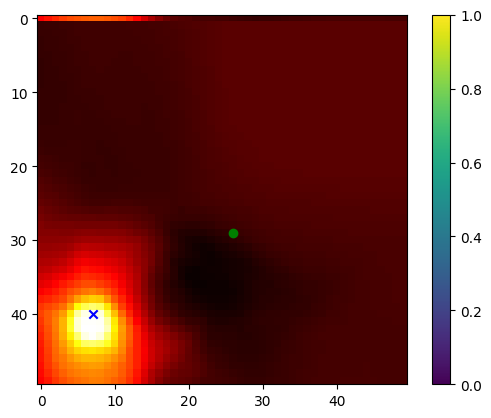

Episode Reward: 1.00
Episode Length 73
initial_agent [[-0.476 -2.78 ]], goal:[[ 0.553 -0.885]]


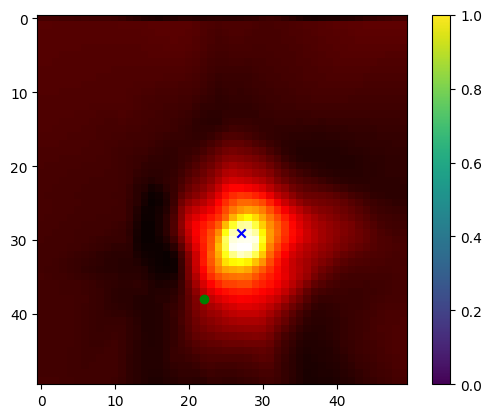

Episode Reward: 0.00
Episode Length 800
initial_agent [[ 2.267 -1.884]], goal:[[2.251 2.179]]


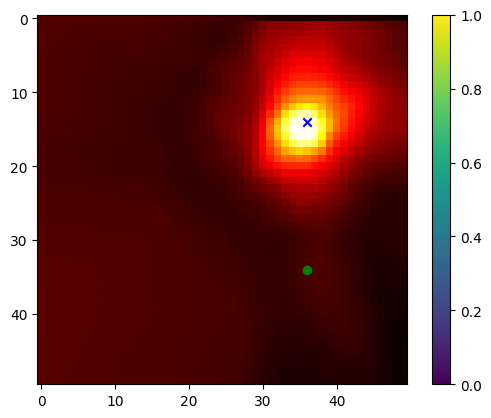

Episode Reward: 0.00
Episode Length 800
initial_agent [[4.402 2.962]], goal:[[-4.318 -2.979]]


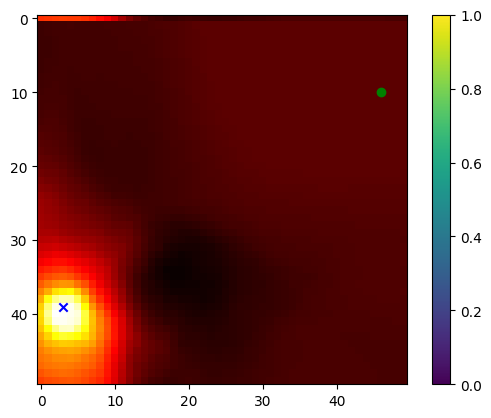

Episode Reward: 1.00
Episode Length 300
initial_agent [[-3.427  3.055]], goal:[[-0.688  1.085]]


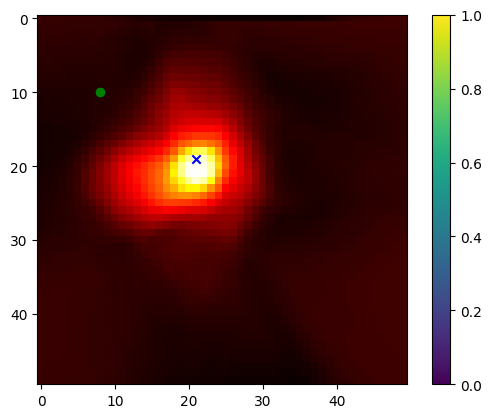

Episode Reward: 0.00
Episode Length 800
initial_agent [[-1.405  1.074]], goal:[[-1.251 -1.76 ]]


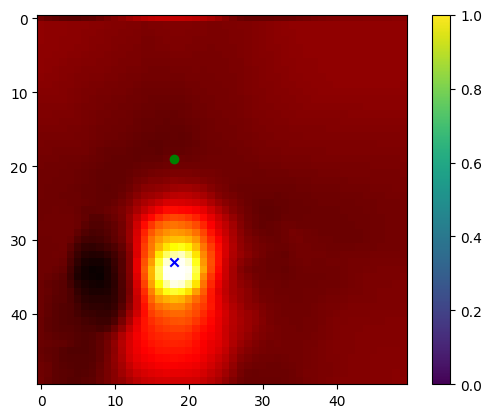

Success rate: 33.33%
6 Episodes
Mean reward: 0.33 +/- 0.47
Mean episode length: 595.50 +/- 296.54


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--env", help="environment ID", type=EnvironmentName, default="CartPole-v1")
parser.add_argument("-f", "--folder", help="Log folder", type=str, default="rl-trained-agents")
parser.add_argument("--algo", help="RL Algorithm", default="ppo", type=str, required=False, choices=list(ALGOS.keys()))
parser.add_argument("-n", "--n-timesteps", help="number of timesteps", default=1000, type=int)
parser.add_argument("--num-threads", help="Number of threads for PyTorch (-1 to use default)", default=-1, type=int)
parser.add_argument("--n-envs", help="number of environments", default=1, type=int)
parser.add_argument("--exp-id", help="Experiment ID (default: 0: latest, -1: no exp folder)", default=0, type=int)
parser.add_argument("--verbose", help="Verbose mode (0: no output, 1: INFO)", default=1, type=int)
parser.add_argument(
    "--no-render", action="store_true", default=False, help="Do not render the environment (useful for tests)"
)
parser.add_argument("--deterministic", action="store_true", default=False, help="Use deterministic actions")
parser.add_argument("--device", help="PyTorch device to be use (ex: cpu, cuda...)", default="auto", type=str)
parser.add_argument(
    "--load-best", action="store_true", default=False, help="Load best model instead of last model if available"
)
parser.add_argument(
    "--load-checkpoint",
    type=int,
    help="Load checkpoint instead of last model if available, "
    "you must pass the number of timesteps corresponding to it",
)
parser.add_argument(
    "--load-last-checkpoint",
    action="store_true",
    default=False,
    help="Load last checkpoint instead of last model if available",
)
parser.add_argument("--stochastic", action="store_true", default=False, help="Use stochastic actions")
parser.add_argument(
    "--norm-reward", action="store_true", default=False, help="Normalize reward if applicable (trained with VecNormalize)"
)
parser.add_argument("--seed", help="Random generator seed", type=int, default=0)
parser.add_argument("--reward-log", help="Where to log reward", default="", type=str)
parser.add_argument(
    "--gym-packages",
    type=str,
    nargs="+",
    default=[],
    help="Additional external Gym environment package modules to import",
)
parser.add_argument(
    "--env-kwargs", type=str, nargs="+", action=StoreDict, help="Optional keyword argument to pass to the env constructor"
)
parser.add_argument(
    "--custom-objects", action="store_true", default=False, help="Use custom objects to solve loading issues"
)
parser.add_argument(
    "-P",
    "--progress",
    action="store_true",
    default=False,
    help="if toggled, display a progress bar using tqdm and rich",
)
parser.add_argument(
    "--render_rgb", action='store_true', default=False, help="if toggled, render rgb array"
)
#args = parser.parse_args()

args = parser.parse_args(args=[])
args.env = EnvironmentName('PointMaze_Large-v3')
args.algo = 'sac'
args.load_last_checkpoint = True
args.no_render = True
args.render_rgb = True
args.folder = './logs/'
#args.exp_id = 9
args.env_kwargs = {'render_mode': 'rgb_array','continuing_task':False}
args.n_timesteps = 4000
enjoy(args)
